# Mastering Gradient Boosting with CatBoost

In this tutorial we will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. [Here](https://www.kaggle.com/c/amazon-employee-access-challenge/data) is the link to the challenge, that we will be exploring.

## Libraries installation

In [0]:
#!pip install --user --upgrade catboost
#!pip install --user --upgrade ipywidgets
#!pip install shap
#!pip install sklearn
#!jupyter nbextension enable --py widgetsnbextension

In [1]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import catboost
print(catboost.__version__)

0.20.2


## Reading the data

In [2]:
from catboost.datasets import amazon

# If you have "URLError: SSL: CERTIFICATE_VERIFY_FAILED" uncomment next two lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# If you have any other error:
# Download datasets from http://bit.ly/2ZUXTSv and uncomment next line:
# train_df = pd.read_csv('train.csv', sep=',', header='infer')

(train_df, test_df) = amazon()

In [3]:
train_df.head()

ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325

## Exploring the data

Label values extraction

In [4]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [5]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Looking on label balance in dataset

In [6]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


# Training the first model

In [7]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=100)
model.fit(X, y, cat_features=cat_features, verbose=10)

Learning rate set to 0.349945
0:	learn: 0.4668712	total: 90.7ms	remaining: 8.98s
10:	learn: 0.1779134	total: 192ms	remaining: 1.56s
20:	learn: 0.1689247	total: 269ms	remaining: 1.01s
30:	learn: 0.1660732	total: 349ms	remaining: 776ms
40:	learn: 0.1647466	total: 438ms	remaining: 630ms
50:	learn: 0.1630501	total: 517ms	remaining: 497ms
60:	learn: 0.1619123	total: 602ms	remaining: 385ms
70:	learn: 0.1606168	total: 694ms	remaining: 284ms
80:	learn: 0.1598533	total: 775ms	remaining: 182ms
90:	learn: 0.1592465	total: 858ms	remaining: 84.9ms
99:	learn: 0.1587221	total: 944ms	remaining: 0us


In [8]:
model.predict_proba(X)

array([[0.0074, 0.9926],
       [0.0094, 0.9906],
       [0.0431, 0.9569],
       ...,
       [0.0106, 0.9894],
       [0.1099, 0.8901],
       [0.0229, 0.9771]])

# Working with dataset

There are several ways of passing dataset to training - using X,y (the initial matrix) or using Pool class.
Pool class is the class for storing the dataset. In the next few blocks we'll explore the ways to create a Pool object.

You can use Pool class if the dataset has more than just X and y (for example, it has sample weights or groups) or if the dataset is large and it takes long time to read it into python.

In [9]:
from catboost import Pool
pool = Pool(data=X, label=y, cat_features=cat_features)

## Split your data into train and validation

In [10]:
from sklearn.model_selection import train_test_split

data = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_validation, y_train, y_validation = data

train_pool = Pool(
    data=X_train, 
    label=y_train, 
    cat_features=cat_features
)

validation_pool = Pool(
    data=X_validation, 
    label=y_validation, 
    cat_features=cat_features
)

## Selecting the objective function

Possible options for binary classification:

`Logloss` for binary target.

`CrossEntropy` for probabilities in target.

In [11]:
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(train_pool, eval_set=validation_pool, verbose=False)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


## Stdout of the training

In [12]:
model = CatBoostClassifier(
    iterations=15,
#     verbose=5,
)
model.fit(train_pool, eval_set=validation_pool);

Learning rate set to 0.5
0:	learn: 0.3966927	test: 0.3956591	best: 0.3956591 (0)	total: 14.6ms	remaining: 205ms
1:	learn: 0.2942358	test: 0.2919936	best: 0.2919936 (1)	total: 27.5ms	remaining: 179ms
2:	learn: 0.2481041	test: 0.2453232	best: 0.2453232 (2)	total: 35.8ms	remaining: 143ms
3:	learn: 0.2230318	test: 0.2190814	best: 0.2190814 (3)	total: 47.3ms	remaining: 130ms
4:	learn: 0.2002549	test: 0.1927695	best: 0.1927695 (4)	total: 55.3ms	remaining: 111ms
5:	learn: 0.1914721	test: 0.1820185	best: 0.1820185 (5)	total: 62.4ms	remaining: 93.5ms
6:	learn: 0.1850864	test: 0.1754934	best: 0.1754934 (6)	total: 70.3ms	remaining: 80.4ms
7:	learn: 0.1829267	test: 0.1726225	best: 0.1726225 (7)	total: 77.6ms	remaining: 67.9ms
8:	learn: 0.1798426	test: 0.1672224	best: 0.1672224 (8)	total: 86ms	remaining: 57.3ms
9:	learn: 0.1781434	test: 0.1655881	best: 0.1655881 (9)	total: 93.1ms	remaining: 46.5ms
10:	learn: 0.1771754	test: 0.1644725	best: 0.1644725 (10)	total: 100ms	remaining: 36.4ms
11:	learn: 0.

## Metrics calculation and graph plotting

In [13]:
model = CatBoostClassifier(
    iterations=50,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Model comparison

In [14]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    train_dir='learing_rate_0.01'
)

model1.fit(train_pool, eval_set=validation_pool, verbose=20)
model2.fit(train_pool, eval_set=validation_pool, verbose=20);

0:	learn: 0.3258230	test: 0.3243318	best: 0.3243318 (0)	total: 15.4ms	remaining: 1.52s
20:	learn: 0.1691117	test: 0.1596568	best: 0.1594555 (18)	total: 170ms	remaining: 638ms
40:	learn: 0.1631269	test: 0.1582470	best: 0.1582470 (40)	total: 319ms	remaining: 459ms
60:	learn: 0.1574848	test: 0.1576933	best: 0.1570204 (46)	total: 461ms	remaining: 295ms
80:	learn: 0.1540453	test: 0.1580379	best: 0.1570204 (46)	total: 623ms	remaining: 146ms
99:	learn: 0.1495245	test: 0.1575826	best: 0.1569796 (85)	total: 765ms	remaining: 0us

bestTest = 0.1569796166
bestIteration = 85

Shrink model to first 86 iterations.
0:	learn: 0.6853670	test: 0.6853478	best: 0.6853478 (0)	total: 11.9ms	remaining: 1.18s
20:	learn: 0.5575475	test: 0.5568142	best: 0.5568142 (20)	total: 150ms	remaining: 565ms
40:	learn: 0.4678037	test: 0.4663655	best: 0.4663655 (40)	total: 286ms	remaining: 412ms
60:	learn: 0.4029115	test: 0.4011251	best: 0.4011251 (60)	total: 393ms	remaining: 251ms
80:	learn: 0.3551495	test: 0.3530158	best:

In [15]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.7', 'learing_rate_0.01']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Best iteration

In [16]:
model = CatBoostClassifier(
    iterations=100,
#     use_best_model=False
)
model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 61


## Cross-validation

In [18]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 80,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [19]:
cv_data.head(10)

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.296906          0.000360            0.299114   
1           1           0.234483          0.001033            0.235491   
2           2           0.195188          0.003147            0.201793   
3           3           0.182960          0.001964            0.191395   
4           4           0.175408          0.002188            0.185331   
5           5           0.172860          0.002752            0.182745   
6           6           0.170483          0.002128            0.179835   
7           7           0.168882          0.003088            0.178182   
8           8           0.167672          0.003570            0.176664   
9           9           0.167082          0.003523            0.175086   

   train-Logloss-std  test-AUC-mean  test-AUC-std  
0           0.000486       0.553022      0.012227  
1           0.000755       0.553732      0.012100  
2           0.002466       0.775604      0.036351  
3           0.001038       0.803924      0.017656  
4           0.001148       0.817129      0.006136  
5           0.001246       0.820936      0.007383  
6           0.001101       0.828831      0.008105  
7           0.000813       0.834187      0.011297  
8           0.000506       0.836562      0.013555  
9           0.000909       0.839657      0.012674

In [20]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1641±0.0060 on step 28


C:\Users\prateek.g\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


In [21]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 80,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
best_value = cv_data['test-Logloss-mean'].min()
best_iter = cv_data['test-Logloss-mean'].values.argmin()

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, stratified: 0.1631±0.0106 on step 33


## Sklearn Grid Search

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "learning_rate": [0.001, 0.01, 0.5],
}

clf = CatBoostClassifier(
    iterations=20, 
    cat_features=cat_features, 
    verbose=20
)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 0.6923673	total: 8.86ms	remaining: 168ms
19:	learn: 0.6778493	total: 101ms	remaining: 0us
0:	learn: 0.6923680	total: 9.03ms	remaining: 172ms
19:	learn: 0.6778556	total: 89.2ms	remaining: 0us
0:	learn: 0.6923673	total: 8.64ms	remaining: 164ms
19:	learn: 0.6778559	total: 95.1ms	remaining: 0us
0:	learn: 0.6853838	total: 11.5ms	remaining: 219ms
19:	learn: 0.5629769	total: 103ms	remaining: 0us
0:	learn: 0.6853905	total: 8.84ms	remaining: 168ms
19:	learn: 0.5630636	total: 88.6ms	remaining: 0us
0:	learn: 0.6853831	total: 9.29ms	remaining: 177ms
19:	learn: 0.5630471	total: 98.5ms	remaining: 0us
0:	learn: 0.3972934	total: 8.71ms	remaining: 166ms
19:	learn: 0.1786463	total: 125ms	remaining: 0us
0:	learn: 0.3976376	total: 8.86ms	remaining: 168ms
19:	learn: 0.1770108	total: 132ms	remaining: 0us
0:	learn: 0.3973406	total: 15ms	remaining: 286ms
19:	learn: 0.1735081	total: 140ms	remaining: 0us
0:	learn: 0.3966927	total: 11ms	remaining: 209ms
19:	learn: 0.1719882	total: 151ms	remaining: 0us


{'iterations': 20,
 'learning_rate': 0.5,
 'verbose': 20,
 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8]}

## Overfitting Detector

In [24]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
print(model_with_early_stop.tree_count_)

41


### Overfitting Detector with eval metric

In [26]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [27]:
print(model_with_early_stop.tree_count_)

32


## Model predictions

In [28]:
model = CatBoostClassifier(iterations=200, learning_rate=0.03)
model.fit(train_pool, verbose=50);

0:	learn: 0.6562528	total: 32.3ms	remaining: 6.43s
50:	learn: 0.1932541	total: 1.06s	remaining: 3.1s
100:	learn: 0.1654166	total: 2.34s	remaining: 2.29s
150:	learn: 0.1582458	total: 4.21s	remaining: 1.37s
199:	learn: 0.1550348	total: 6.3s	remaining: 0us


In [29]:
print(model.predict(X_validation))

[1. 1. 1. ... 1. 1. 1.]


In [30]:
print(model.predict_proba(X_validation))

[[0.0279 0.9721]
 [0.0228 0.9772]
 [0.0103 0.9897]
 ...
 [0.0416 0.9584]
 [0.0404 0.9596]
 [0.0205 0.9795]]


In [31]:
raw_pred = model.predict(
    X_validation,
    prediction_type='RawFormulaVal'
)

print(raw_pred)

[3.5496 3.7582 4.5687 ... 3.1378 3.1682 3.8688]


In [32]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9721 0.9772 0.9897 ... 0.9584 0.9596 0.9795]


## Select decision boundary

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [33]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(model, validation_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

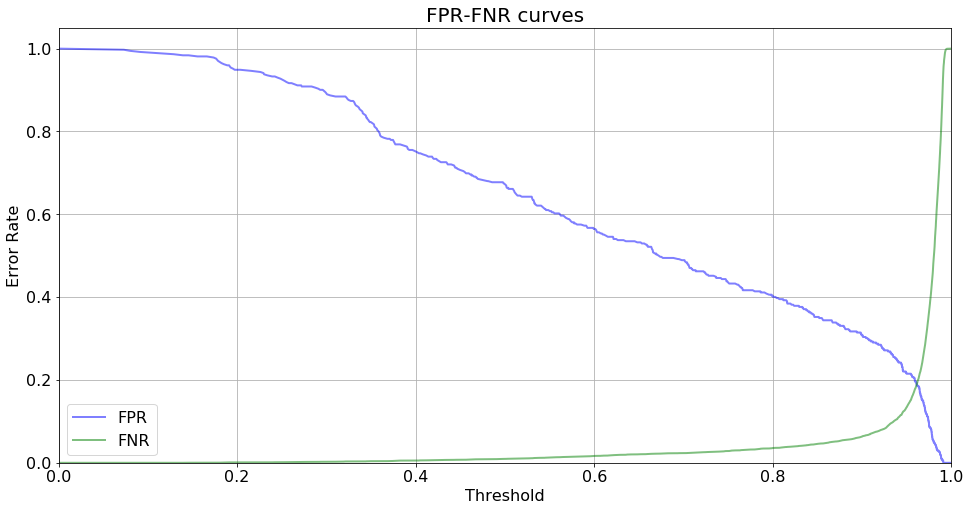

In [34]:
plt.figure(figsize=(16, 8))
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16);

In [35]:
from catboost.utils import select_threshold

print(select_threshold(model, validation_pool, FNR=0.01))
print(select_threshold(model, validation_pool, FPR=0.01))

0.5035400410495793
0.9891505266321952


## Metric evaluation on a new dataset

In [36]:
metrics = model.eval_metrics(
    data=validation_pool,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
print('AUC values:\n{}'.format(np.array(metrics['AUC'])))

AUC values:
[0.5509 0.5509 0.5806 0.5824 0.5719 0.5758 0.583  0.583  0.583  0.5834
 0.5824 0.5749 0.5749 0.6635 0.6823 0.698  0.7028 0.7046 0.7023 0.7062
 0.7264 0.7271 0.7284 0.7284 0.7376 0.7419 0.7755 0.778  0.7782 0.7794
 0.7926 0.7925 0.8037 0.805  0.8112 0.8167 0.8201 0.8232 0.8286 0.8307
 0.8328 0.8335 0.8342 0.8354 0.8359 0.8366 0.8373 0.8375 0.8403 0.841
 0.8412 0.8414 0.8419 0.8435 0.8438 0.8439 0.8441 0.8457 0.8458 0.8459
 0.8463 0.8467 0.8468 0.8469 0.8472 0.8472 0.8475 0.8476 0.8481 0.8481
 0.8491 0.8491 0.8527 0.856  0.8592 0.8615 0.863  0.8645 0.8663 0.8674
 0.8681 0.8693 0.87   0.8707 0.8713 0.872  0.8743 0.8758 0.8772 0.879
 0.88   0.8813 0.8823 0.8833 0.884  0.8848 0.8857 0.8862 0.8866 0.8871
 0.8875 0.888  0.8885 0.889  0.8892 0.8894 0.8896 0.89   0.89   0.8903
 0.8904 0.8904 0.8906 0.8906 0.8909 0.891  0.891  0.8911 0.8915 0.8917
 0.8919 0.892  0.8921 0.8922 0.8925 0.8925 0.8926 0.8927 0.8928 0.8928
 0.8928 0.8928 0.8928 0.8927 0.8927 0.8928 0.8929 0.8931 0.8932 0.8

## Feature importances

### Prediction values change

Default feature importances for binary classification is PredictionValueChange - how much on average does the model change when the feature value changes.
These feature importances are non negative.
They are normalized and sum to 1, so you can look on these values like percentage of importance.

In [38]:
np.array(model.get_feature_importance(prettified=True))

array([['RESOURCE', 22.383970007742516],
       ['MGR_ID', 18.761141841081145],
       ['ROLE_DEPTNAME', 17.192053756727123],
       ['ROLE_TITLE', 8.91333535124119],
       ['ROLE_CODE', 8.74345192212495],
       ['ROLE_FAMILY_DESC', 8.435115053491474],
       ['ROLE_ROLLUP_2', 6.926178207913807],
       ['ROLE_FAMILY', 4.341449968457741],
       ['ROLE_ROLLUP_1', 4.303303891220086]], dtype=object)

### Loss function change

The non default feature importance approximates how much the optimized loss function will change if the value of the feature changes.
This importances might be negative if the feature has bad influence on the loss function.
The importances are not normalized, the absolute value of the importance has the same scale as the optimized loss value.
To calculate this importance value you need to pass train_pool as an argument.

In [39]:
np.array(model.get_feature_importance(
    train_pool, 
    'LossFunctionChange', 
    prettified=True
))

array([['RESOURCE', 0.0194333597405903],
       ['MGR_ID', 0.01594543975865079],
       ['ROLE_DEPTNAME', 0.010659264616722185],
       ['ROLE_TITLE', 0.010608085786365323],
       ['ROLE_FAMILY_DESC', 0.009246267589196283],
       ['ROLE_ROLLUP_2', 0.004193098123614425],
       ['ROLE_CODE', 0.0027508511487738183],
       ['ROLE_FAMILY', 8.512637228771935e-06],
       ['ROLE_ROLLUP_1', -2.0406112467674653e-05]], dtype=object)

### Shap values

In [40]:
print(model.predict_proba([X.iloc[1,:]]))
print(model.predict_proba([X.iloc[91,:]]))

[[0.0114 0.9886]]
[[0.4122 0.5878]]


In [41]:
shap_values = model.get_feature_importance(
    validation_pool, 
    'ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(6554, 9)


In [42]:
proba = model.predict_proba([X.iloc[1,:]])[0]
raw = model.predict([X.iloc[1,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities [0.0114 0.9886]
Raw formula value 4.4669
Probability from raw value 0.9886


In [43]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_validation.iloc[1,:])

ModuleNotFoundError: No module named 'shap'

In [44]:
proba = model.predict_proba([X.iloc[91,:]])[0]
raw = model.predict([X.iloc[91,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities [0.4122 0.5878]
Raw formula value 0.3548
Probability from raw value 0.5878


In [45]:
import shap
shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X_validation.iloc[91,:])

ModuleNotFoundError: No module named 'shap'

In [46]:
shap.summary_plot(shap_values, X_validation)

NameError: name 'shap' is not defined

## Snapshotting

In [47]:
#!rm 'catboost_info/snapshot.bkp'

model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1
)

model.fit(train_pool, eval_set=validation_pool, verbose=10);

Learning rate set to 0.294577
0:	learn: 0.4962935	test: 0.4957036	best: 0.4957036 (0)	total: 12.6ms	remaining: 1.25s
10:	learn: 0.1892121	test: 0.1811053	best: 0.1811053 (10)	total: 109ms	remaining: 881ms
20:	learn: 0.1746743	test: 0.1625924	best: 0.1625924 (20)	total: 226ms	remaining: 850ms
30:	learn: 0.1716788	test: 0.1589853	best: 0.1589853 (30)	total: 319ms	remaining: 710ms
40:	learn: 0.1704676	test: 0.1582453	best: 0.1582453 (40)	total: 423ms	remaining: 608ms
50:	learn: 0.1679535	test: 0.1568791	best: 0.1568791 (50)	total: 518ms	remaining: 497ms
60:	learn: 0.1664267	test: 0.1560672	best: 0.1560672 (60)	total: 621ms	remaining: 397ms
70:	learn: 0.1655492	test: 0.1564357	best: 0.1560672 (60)	total: 740ms	remaining: 302ms
80:	learn: 0.1650917	test: 0.1565706	best: 0.1560672 (60)	total: 842ms	remaining: 198ms
90:	learn: 0.1644001	test: 0.1568892	best: 0.1560672 (60)	total: 952ms	remaining: 94.1ms
99:	learn: 0.1637055	test: 0.1567746	best: 0.1560672 (60)	total: 1.02s	remaining: 0us

bes

## Saving the model

In [48]:
model = CatBoostClassifier(iterations=10)
model.fit(train_pool, eval_set=validation_pool, verbose=False)
model.save_model('catboost_model.bin')
model.save_model('catboost_model.json', format='json')

In [49]:
model.load_model('catboost_model.bin')
print(model.get_params())
print(model.learning_rate_)

{'iterations': 10, 'loss_function': 'Logloss', 'logging_level': 'Silent', 'verbose': 0}
0.5


## Hyperparameter tunning

In [50]:
tunned_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1
)

tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Speeding up the training

In [0]:
fast_model = CatBoostClassifier(
    boosting_type='Plain',
    rsm=0.5,
    one_hot_max_size=50,
    leaf_estimation_iterations=1,
    max_ctr_complexity=1,
    iterations=100,
    learning_rate=0.3,
    bootstrap_type='Bernoulli',
    subsample=0.5
)
fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
);

# Reducing model size

In [0]:
small_model = CatBoostClassifier(
    learning_rate=0.03,
    iterations=500,
    model_size_reg=50,
    max_ctr_complexity=1,
    ctr_leaf_count_limit=100
)
small_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
);